In [1]:
from PIL import Image
import numpy as np
import random
import glob
import cv2
from scipy.linalg import hadamard
from scipy import signal
import matplotlib.pyplot as plt
from quantizer import *

# Numerical experiments in Section 6

In [2]:
k = 1000    # size of dataset
n = 16384   # dim of input vectors (flattened grayscale images with size 128 * 128)
delta = 1   # parameters of sign function 
q = 1950/n     # sparsity constant of random matrices 
H = hadamard(n)/np.sqrt(n)    
D = np.diag(2 * np.random.binomial(1, 0.5, size=n) - 1)

m_list = [pow(2,i) for i in range(9,15)]   # m is the number of measurements and m = p * lambda
p_list = [32, 64, 128]          # p is the embedding dimsion 
mse_dist = np.zeros((len(p_list),len(m_list)))  
mse_norm = np.zeros((len(p_list),len(m_list)))
mse_dist_abs = np.zeros((len(p_list),len(m_list)))
mse_norm_abs = np.zeros((len(p_list),len(m_list)))
mse_JL = np.zeros((len(p_list),len(m_list)))
mse_JL_abs = np.zeros((len(p_list),len(m_list)))

In [3]:
image_list = []
for filename in random.sample(glob.glob('yelp_photos/photos/*.jpg'),k):  # load Yelp dataset
    im = Image.open(filename).convert(mode='L').resize((128,128))
    im_vec = np.asarray(im).flatten().reshape((n,1))
    image_list.append(im_vec)   
scalar = max(map(np.linalg.norm, image_list)) * 1.5 
image_list = [item/scalar for item in image_list]

In [4]:
for j in range(len(m_list)):   #FJLT
    m = m_list[j]
    A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
    Phi = A@H@D
    binary_list = second_quantizer(Phi, image_list, delta)
    for i in range(len(p_list)):
        p = p_list[i]
        lam = int(m/p)
        v = np.ones(lam) 
        V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
        mse_dist[i, j], mse_dist_abs[i, j] = error_dist(V, image_list, binary_list) 
        

for j in range(len(m_list)):    #SJLT
    m = m_list[j]
    A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
    binary_list = second_quantizer(A, image_list, delta)
    for i in range(len(p_list)):
        p = p_list[i]
        lam = int(m/p)
        v = np.ones(lam) 
        V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
        mse_dist[i, j], mse_dist_abs[i, j] = error_dist(V, image_list, binary_list) 

## First order quantization plot

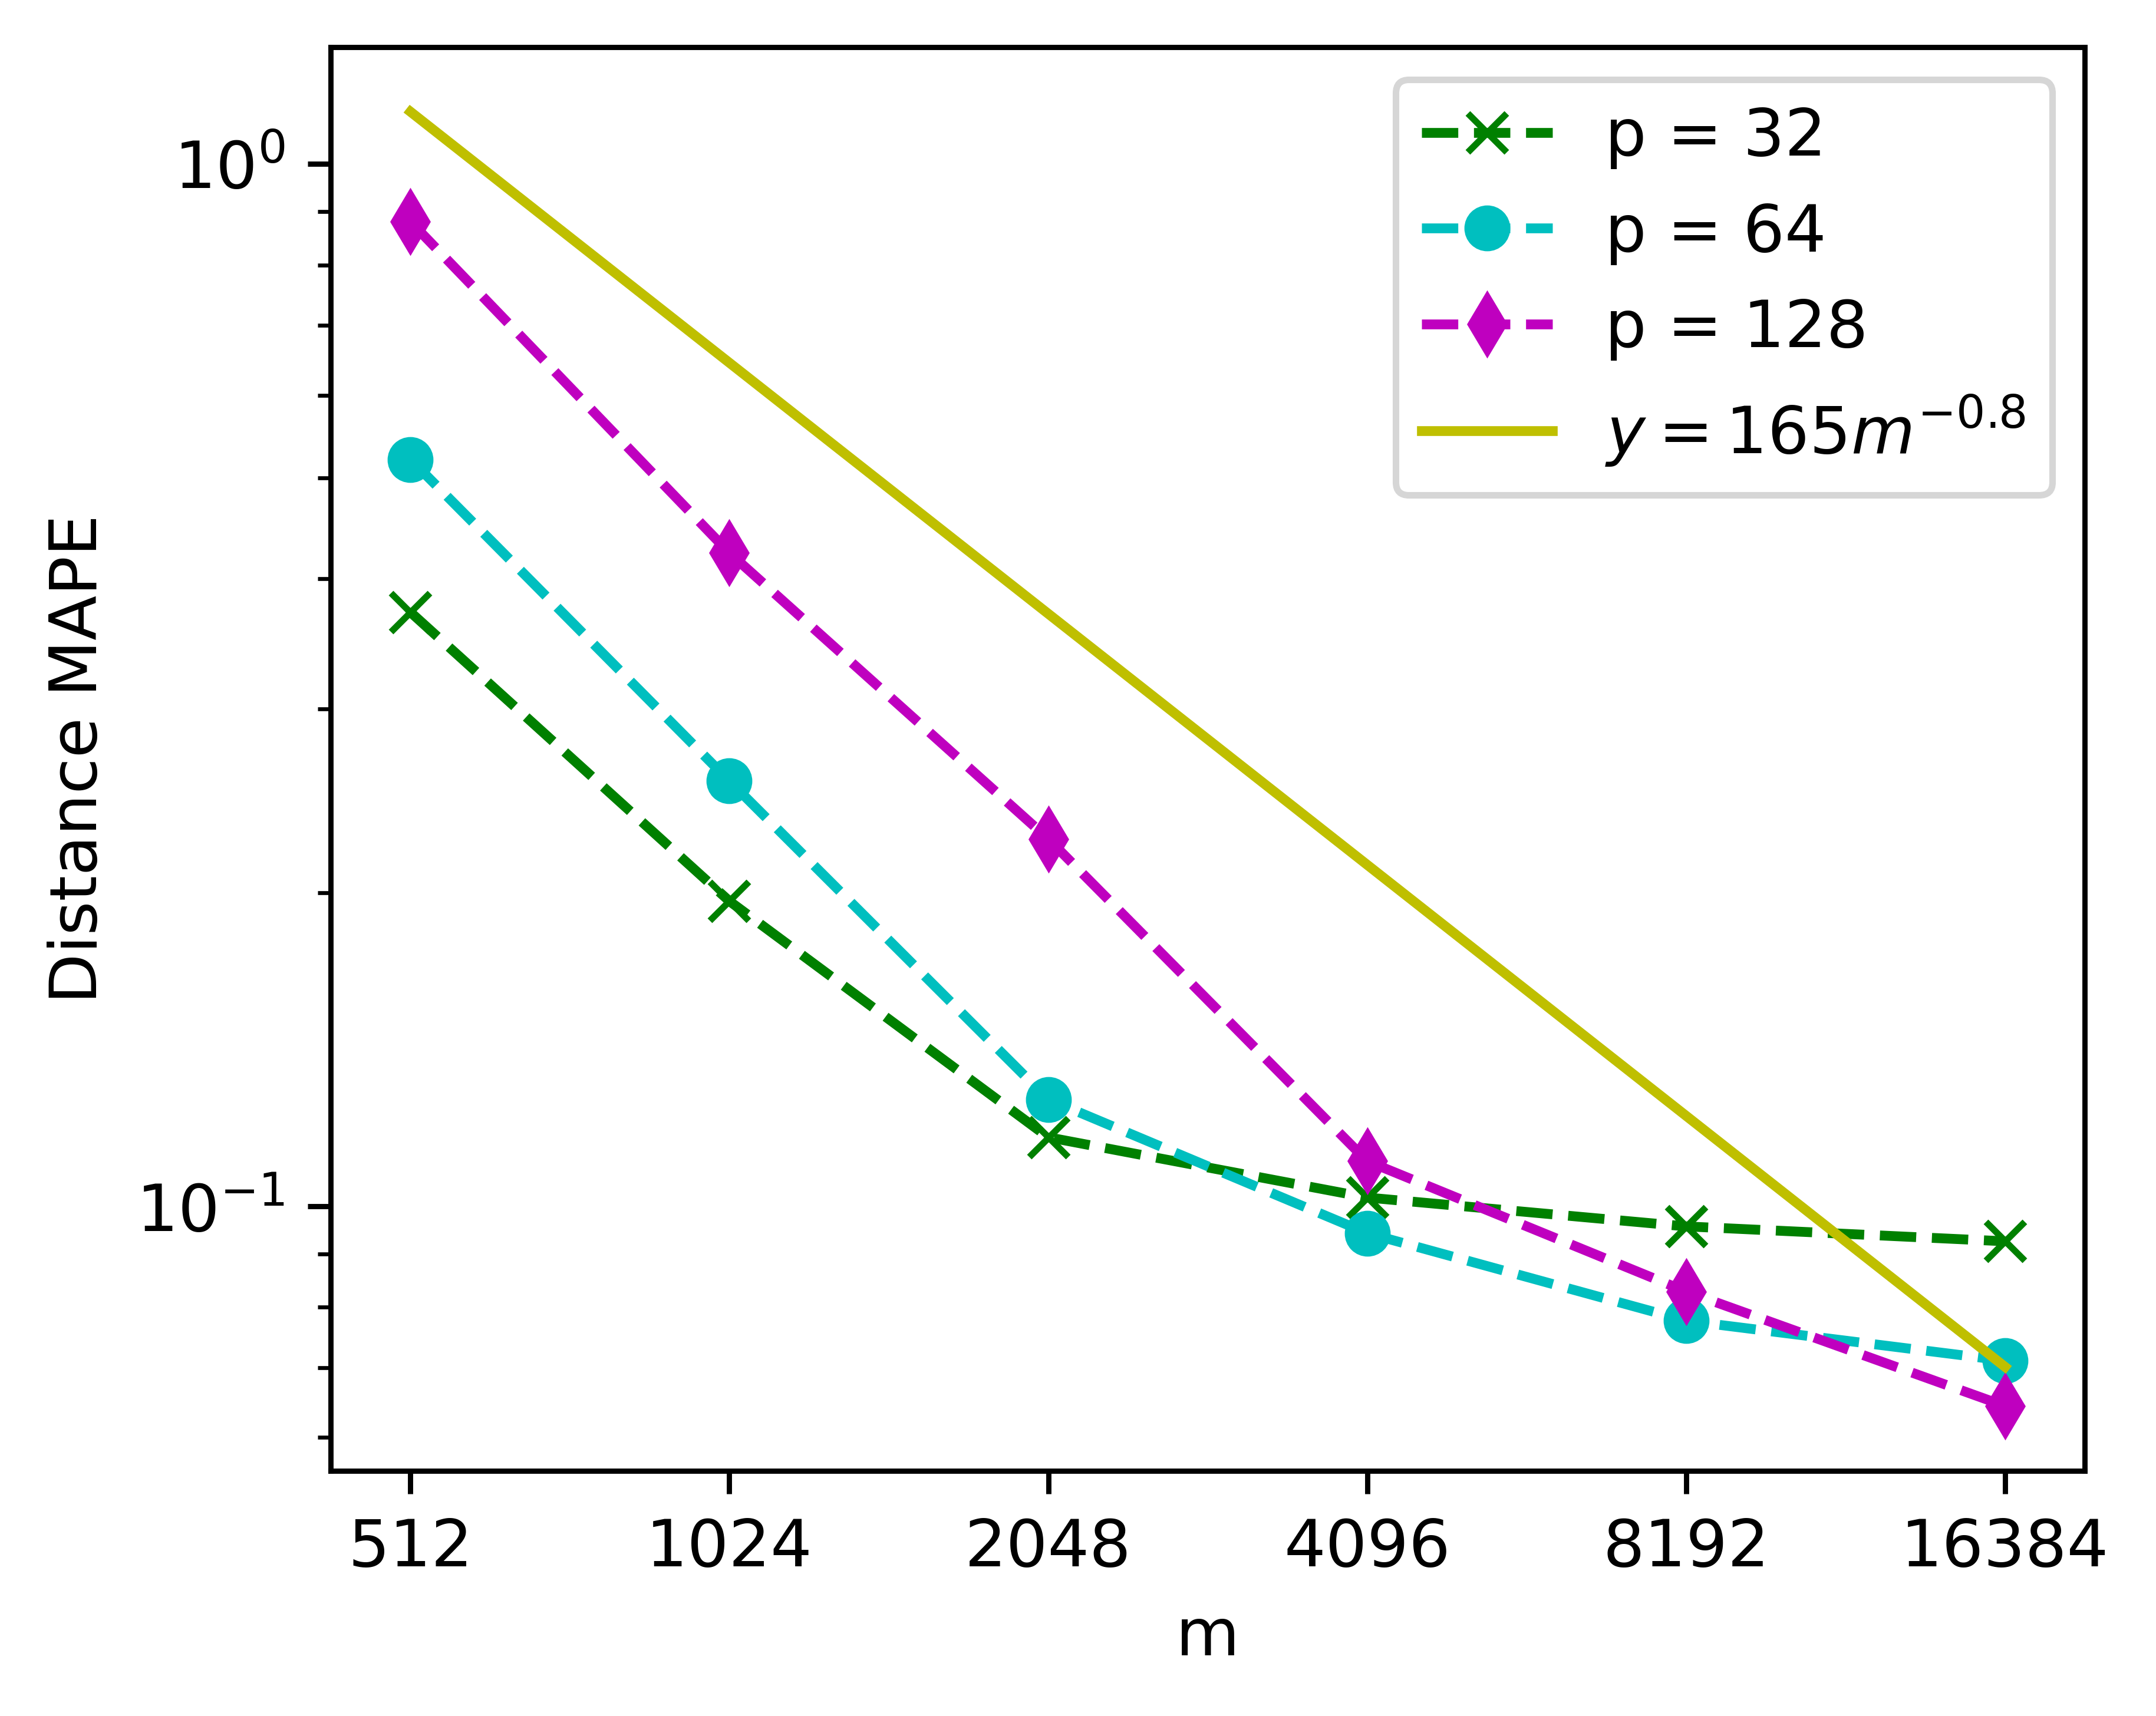

In [30]:
col = ['g', 'c', 'm']     
mar = ['x', 'o', 'd']
fig = plt.figure(figsize=(4.8,4), dpi=800)
ax = fig.add_subplot(1,1,1)
m_list = [pow(2,i) for i in range(9,15)]

for i in range(mse_dist.shape[0]):
    ax.plot(m_list, mse_dist[i,:], color=col[i], linestyle='--', marker=mar[i], label = 'p = %d' % p_list[i])

ax.plot(m_list, [165*m**(-0.8) for m in m_list], color='y', linestyle='-', label = '$y=165m^{-0.8}$')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log', base=2)
ax.set_xticks(m_list)
ax.set_xticklabels(m_list)
ax.set_xlabel('m')
ax.set_ylabel('Distance MAPE')

## Comparison between quantizers with optimal $p$

In [6]:
from sympy import poly
from sympy.abc import x

coef0 = poly(sum([x**i for i in range(11)]) **3,x).all_coeffs() 
coef1 = poly(sum([x**i for i in range(11)]) **3,x).all_coeffs() 
coef2 = poly(sum([x**i for i in range(12)]) **3,x).all_coeffs() 
coef3 = poly(sum([x**i for i in range(15)]) **3,x).all_coeffs() 
coef4 = poly(sum([x**i for i in range(19)]) **3,x).all_coeffs() 
coef5 = poly(sum([x**i for i in range(22)]) **3,x).all_coeffs() 

m_list = np.array([[120,264,528,1032,2048,4096], [128,256,512,1024,2048, 4096], [124, 248, 544, 1032, 2035, 4096],[128,256,512,1024,2048,4096]])
coef_list = [coef0, coef1, coef2, coef3, coef4, coef5]
p_list = np.array([ [24,24,24,24,32,64], [8, 16, 32, 32, 64, 64], [4,8,16, 24, 37, 64],  [64, 128, 256, 512, 1024, 2048]])
quantizer_list = [greedy_quantizer, second_quantizer, third_quantizer]
mse_dist = np.zeros((4,m_list.shape[1]))
mse_norm = np.zeros((4,m_list.shape[1]))
mse_dist_abs = np.zeros((4,m_list.shape[1]))
mse_norm_abs = np.zeros((4,m_list.shape[1]))

In [7]:
for j in range(m_list.shape[1]):  #FJLT
    m = m_list[3, j]
    A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
    Phi = A@H@D
    p = p_list[3,j]
    lam = int(m/p)
    v = np.ones(lam)
    V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
    mse_dist[3, j], mse_dist_abs[3, j] = error_JL_dist(Phi, V, image_list) 
    

for j in range(m_list.shape[1]):  #SJLT
    m = m_list[3, j]
    A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
    Phi = A
    p = p_list[3,j]
    lam = int(m/p)
    v = np.ones(lam)
    V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
    mse_dist[3, j], mse_dist_abs[3, j] = error_JL_dist(Phi, V, image_list) 
    

for j in range(m_list.shape[1]):
    for i in range(3):
        m = m_list[i, j]
        A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
        Phi = A@H@D   #FJLT  A@H@D
        p = p_list[i,j]
        lam = int(m/p)
        quantizer = quantizer_list[i]
        if i == 0:
            v = np.ones(lam)
        elif i == 1:
            if lam % 2 == 1:
                v = np.concatenate([np.arange(1,(lam+1)/2+1), np.arange((lam-1)/2, 0, -1)])
            else:
                v = np.concatenate([np.arange(1,lam/2+1), np.arange(lam/2, 0, -1)])
        else:
            v = np.asarray(coef_list[j],dtype=np.float64)[:lam]
        V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
        binary_list = quantizer(Phi, image_list, delta)
        mse_dist[i, j], mse_dist_abs[i, j] = error_dist(V, image_list, binary_list) 

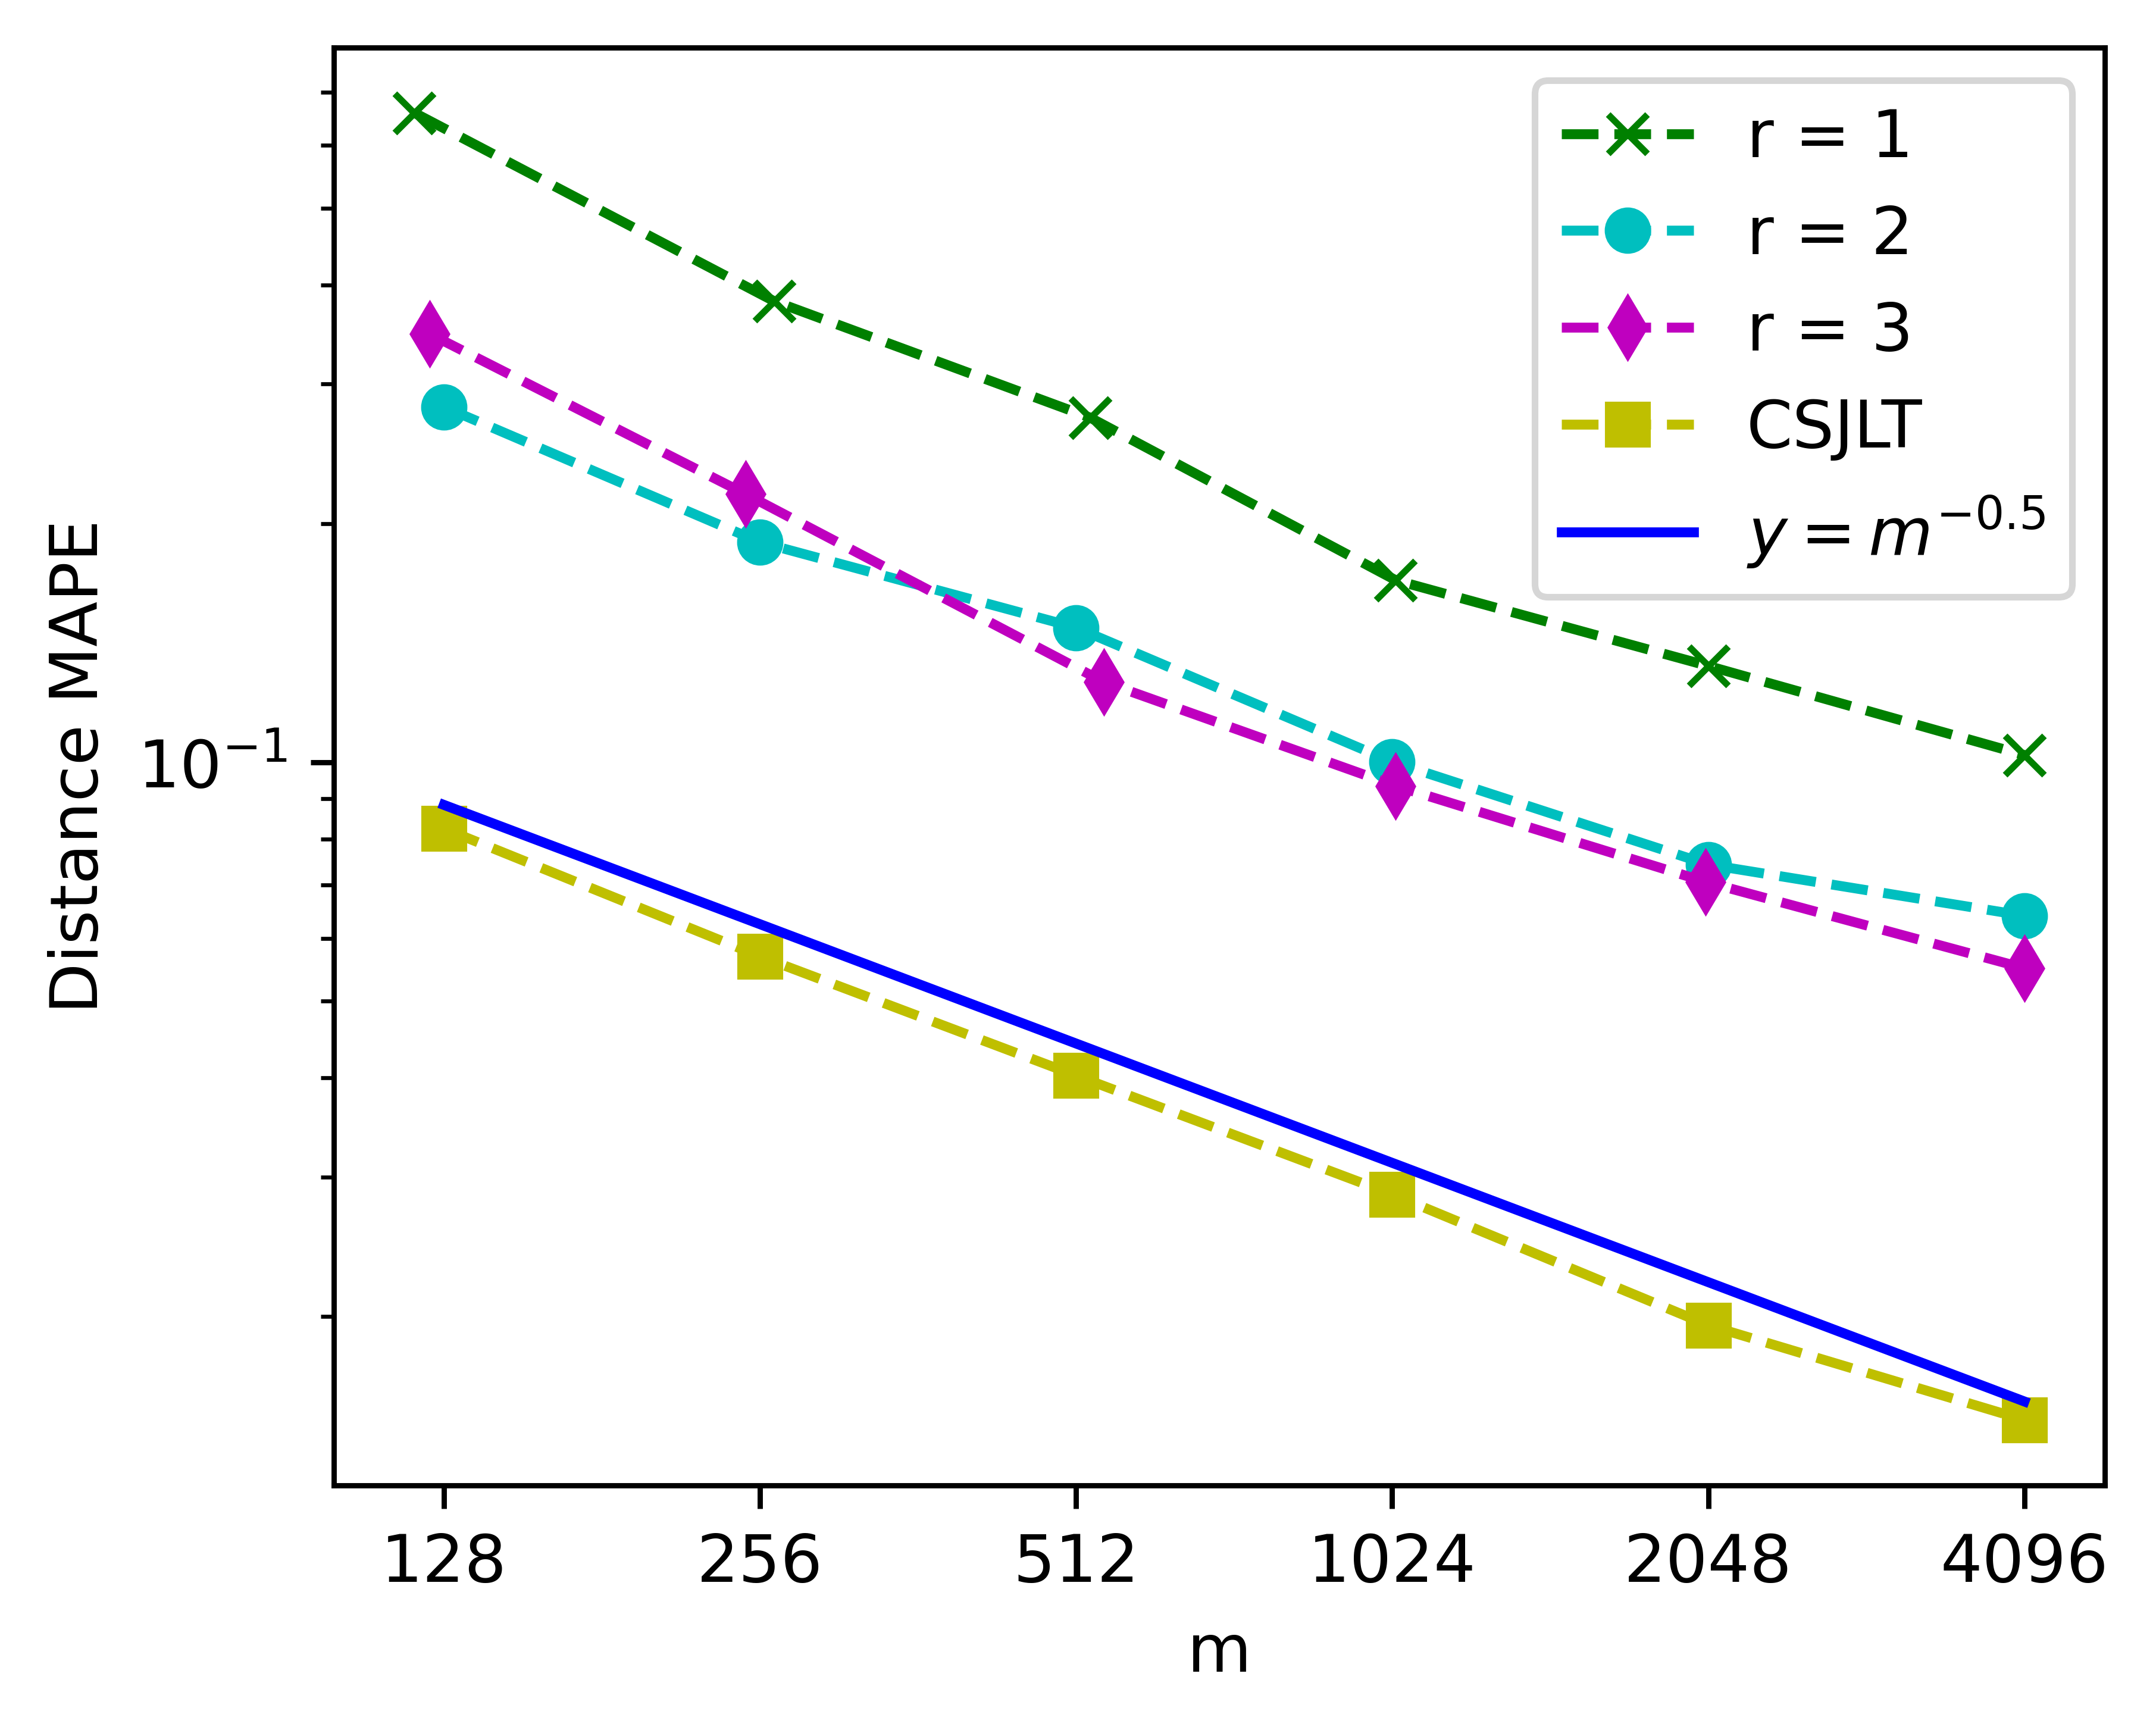

In [18]:
col = ['g', 'c', 'm', 'y']     
mar = ['x', 'o', 'd', 's']
r = ['r = 1', 'r = 2', 'r = 3', 'CSJLT']
fig = plt.figure(figsize=(4.8,4), dpi=800)
ax = fig.add_subplot(1,1,1)
num_list = [2**i for i in np.arange(7,12.1,0.1)]

for i in range(mse_dist.shape[0]):
    ax.plot(m_list[i,:], mse_dist[i,:], color=col[i], linestyle='--', marker=mar[i], label = r[i])

ax.plot(num_list, [m**(-0.5) for m in num_list], color='b', linestyle='-', label = '$y=m^{-0.5}$')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log', base=2)
ax.set_xticks(np.array([128,256,512,1024,2048,4096]))
ax.set_xticklabels(np.array([128,256,512,1024,2048,4096]))
ax.set_xlabel('m')
ax.set_ylabel('Distance MAPE')

## Comparison between quantizers with fixed $p=64$

In [19]:
from sympy import poly
from sympy.abc import x

coef0 = poly(sum([x**i for i in range(2)]) **3,x).all_coeffs() 
coef1 = poly(sum([x**i for i in range(4)]) **3,x).all_coeffs() 
coef2 = poly(sum([x**i for i in range(6)]) **3,x).all_coeffs() 
coef3 = poly(sum([x**i for i in range(12)]) **3,x).all_coeffs() 
coef4 = poly(sum([x**i for i in range(22)]) **3,x).all_coeffs() 

m_list = np.array([[256,512,1024,2048, 4096], [256,512,1024,2048, 4096], [256, 640, 1024, 2176, 4096],[256,512,1024,2048, 4096]])
coef_list = [coef0, coef1, coef2, coef3, coef4]
p = 64
quantizer_list = [greedy_quantizer, second_quantizer, third_quantizer]
mse_dist = np.zeros((4,m_list.shape[1]))
mse_dist_abs = np.zeros((4,m_list.shape[1]))


for j in range(m_list.shape[1]):
    m = m_list[3, j]
    A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
    Phi = A
    lam = int(m/p)
    v = np.ones(lam)
    V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
    mse_dist[3, j], mse_dist_abs[3, j] = error_JL_dist(Phi, V, image_list) 


for j in range(m_list.shape[1]): 
    for i in range(3):
        m = m_list[i, j]
        A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
        Phi = A
        lam = int(m/p)
        quantizer = quantizer_list[i]
        if i == 0:
            v = np.ones(lam)
        elif i == 1:
            if lam % 2 == 1:
                v = np.concatenate([np.arange(1,(lam+1)/2+1), np.arange((lam-1)/2, 0, -1)])
            else:
                v = np.concatenate([np.arange(1,lam/2+1), np.arange(lam/2, 0, -1)])
        else:
            v = np.asarray(coef_list[j],dtype=np.float64)[:lam]
        V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
        binary_list = quantizer(Phi, image_list, delta)
        mse_dist[i, j], mse_dist_abs[i, j] = error_dist(V, image_list, binary_list) 

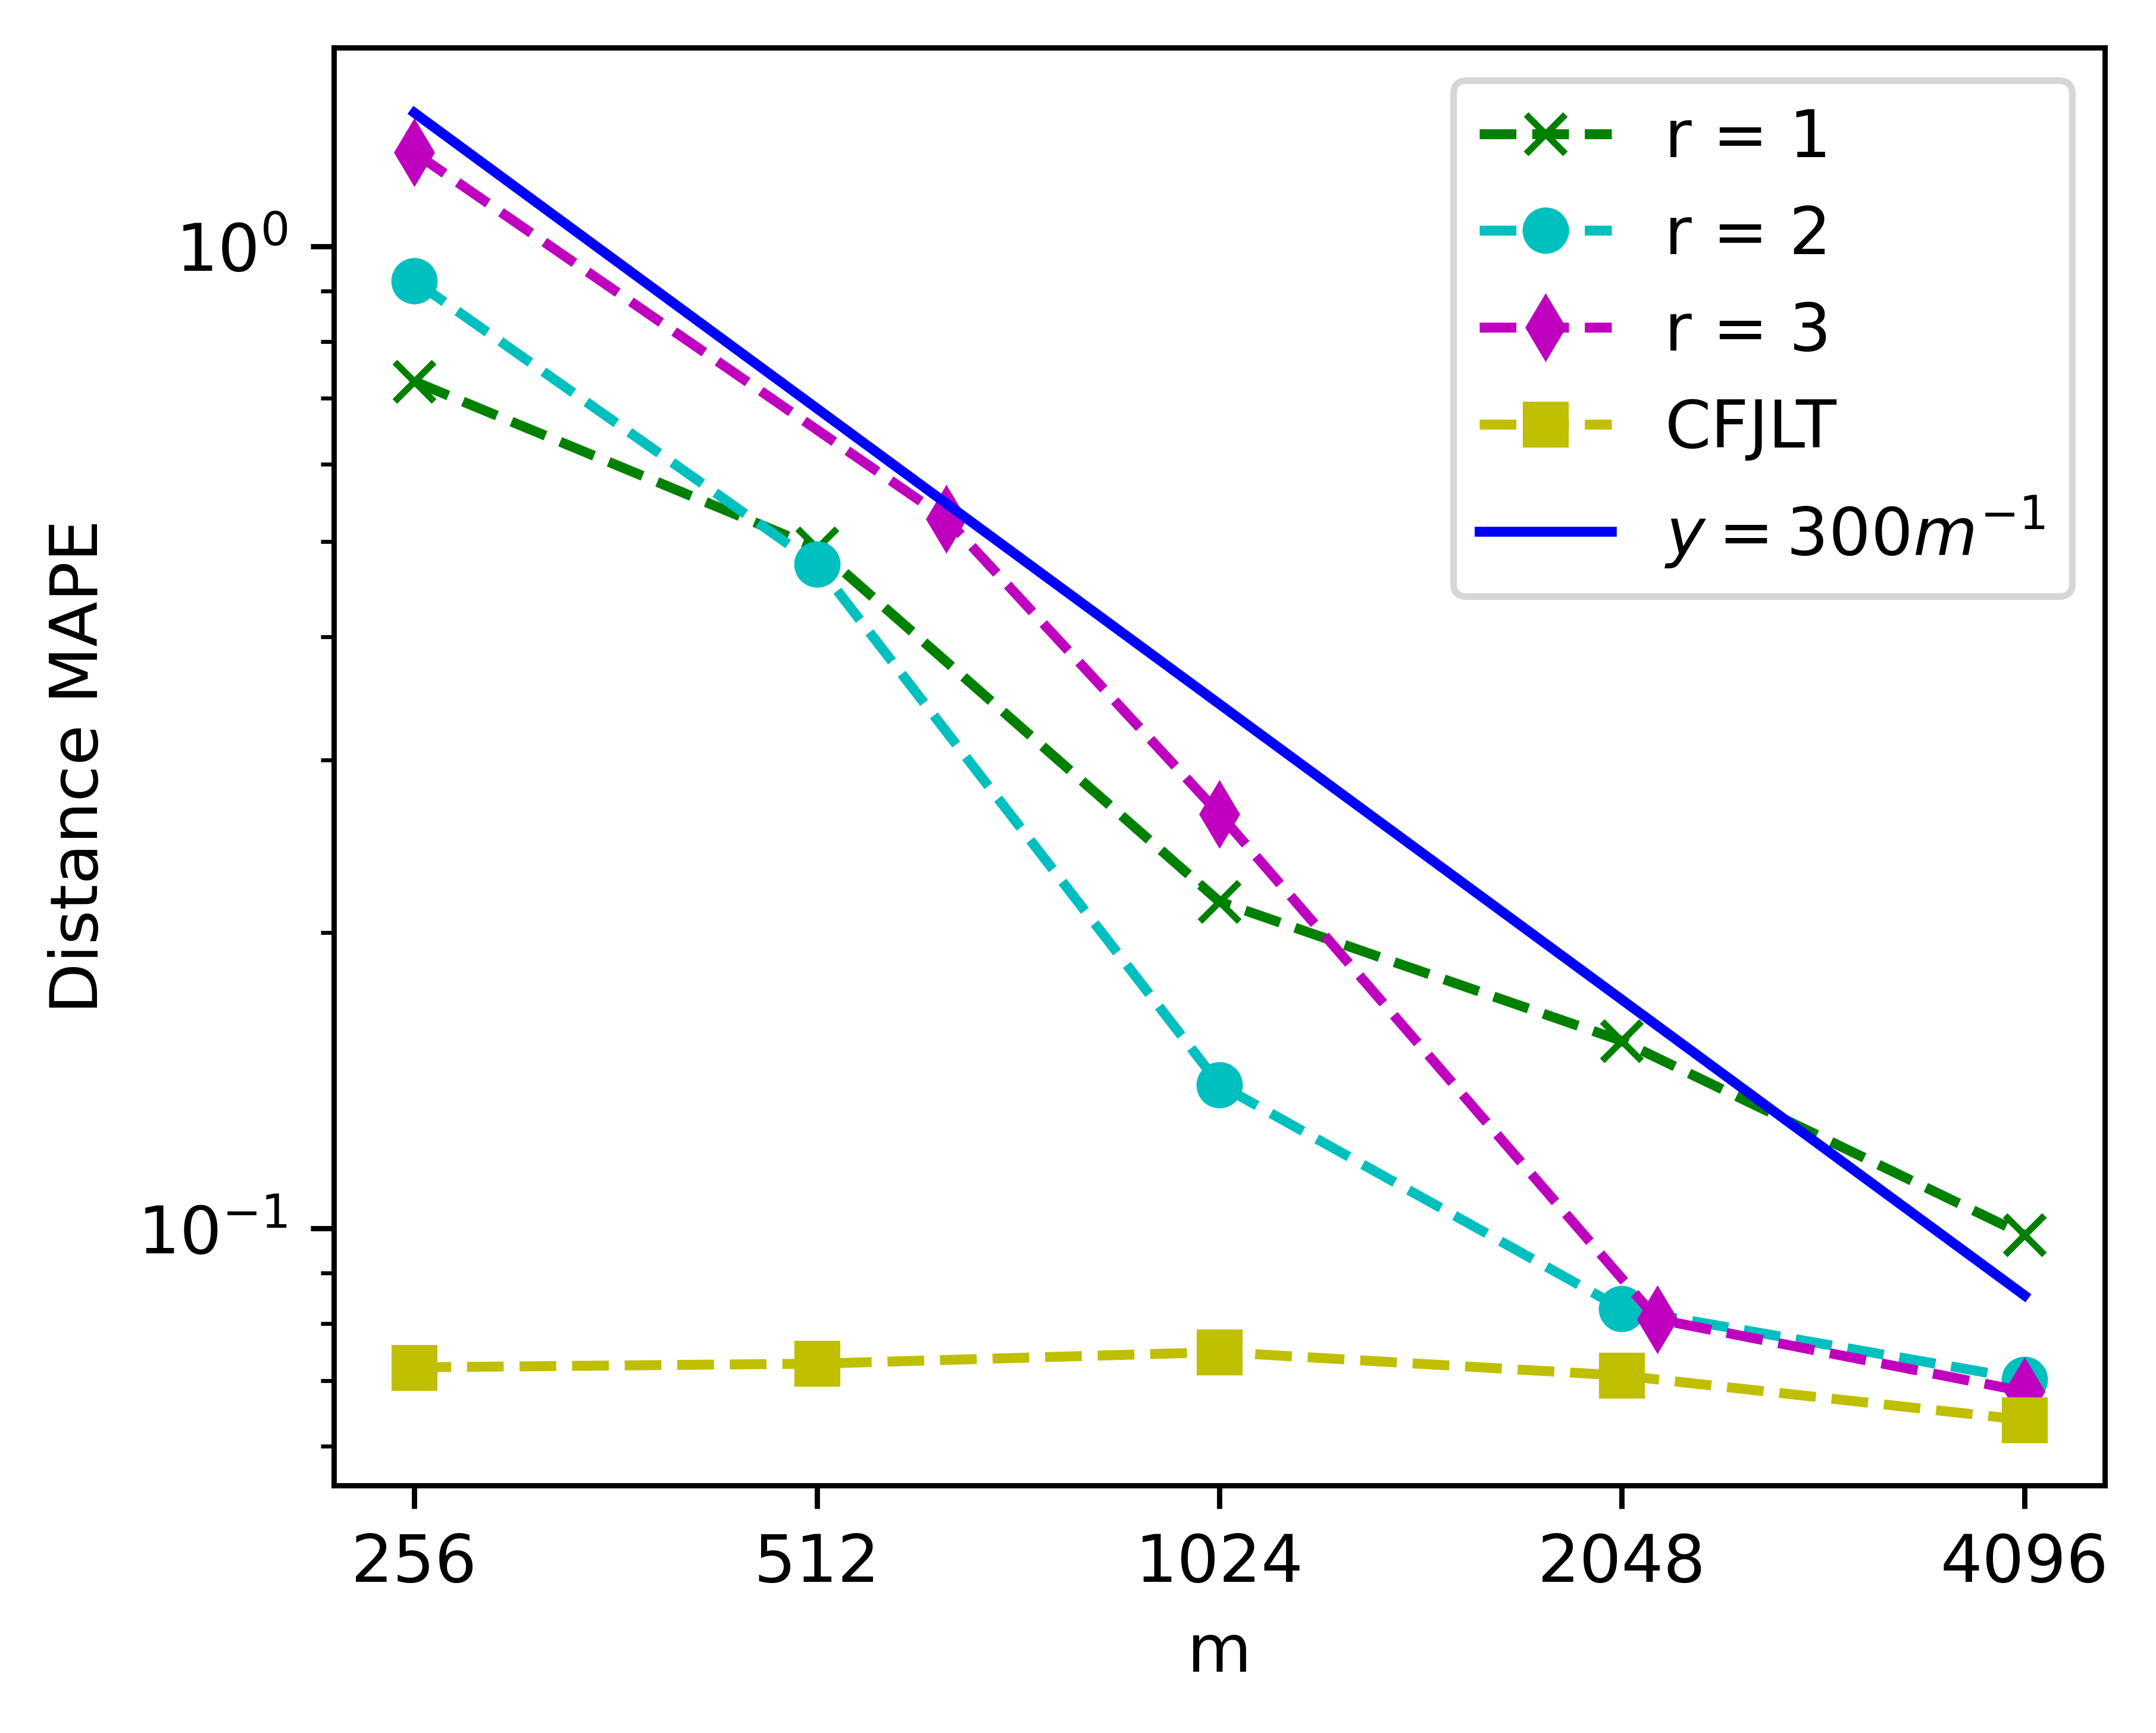

In [23]:
col = ['g', 'c', 'm', 'y']     
mar = ['x', 'o', 'd', 's']
r = ['r = 1', 'r = 2', 'r = 3', 'CFJLT']
fig = plt.figure(figsize=(4.8,4),dpi=800)
ax = fig.add_subplot(1,1,1)
values = [2**i for i in np.arange(8,12.1,0.1)]

for i in range(mse_dist.shape[0]):
    ax.plot(m_list[i,:], mse_dist[i,:], color=col[i], linestyle='--', marker = mar[i], label = r[i])

ax.plot(values, [350*m**(-1) for m in values], color='b', linestyle='-', label = '$y=300m^{-1}$')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log', base=2)
ax.set_xticks(np.array([256,512,1024,2048,4096]))
ax.set_xticklabels(np.array([256,512,1024,2048,4096]))
ax.set_xlabel('m')
ax.set_ylabel('Distance MAPE')

## Extra experiments for datasets: Yelp, ImageNet, Flickr30k, CIFAR10

In [ ]:
k = 1000  # parameters
n = 16384
delta = 1    
q = 1950/n
p = 64
m_list1 = [pow(2,i) for i in range(9,15)]
m_list2 = [576, 1088, 2112, 4160, 8256, 16448] 
mse_dist1 = np.zeros((4,len(m_list1)))  # when r=1
mse_dist2 = np.zeros((4,len(m_list2)))  # when r=2

In [ ]:
yelp_list = []
imagenet_list = []
flickr_list = []
cifar_list = []

for filename in random.sample(glob.glob('yelp_photos/photos/*.jpg'),k):  # load Yelp dataset
    im = Image.open(filename).convert(mode='L').resize((128,128))
    im_vec = np.asarray(im).flatten().reshape((n,1))
    yelp_list.append(im_vec)   
scalar = max(map(np.linalg.norm, yelp_list)) * 1.5
yelp_list = [item/scalar for item in yelp_list]

for filename in random.sample(glob.glob('ImageNet/*.JPEG'),k):  # load ImageNet dataset
    im = Image.open(filename).convert(mode='L').resize((128,128))
    im_vec = np.asarray(im).flatten().reshape((n,1))
    imagenet_list.append(im_vec)   
scalar = max(map(np.linalg.norm, imagenet_list)) * 1.5
imagenet_list = [item/scalar for item in imagenet_list]

for filename in random.sample(glob.glob('flickr30k/images/*.jpg'),k):  # load Flickr30k dataset
    im = Image.open(filename).convert(mode='L').resize((128,128))
    im_vec = np.asarray(im).flatten().reshape((n,1))
    flickr_list.append(im_vec)   
scalar = max(map(np.linalg.norm, flickr_list)) * 1.5
flickr_list = [item/scalar for item in flickr_list]

for filename in random.sample(glob.glob('CIFAR10/*.jpg'),k):  # load CIFAR10 dataset
    im = Image.open(filename).convert(mode='L')
    im_vec = np.asarray(im).flatten().reshape((1024,1))
    cifar_list.append(im_vec)   
scalar = max(map(np.linalg.norm, cifar_list)) * 1.5
cifar_list = [item/scalar for item in cifar_list]

In [ ]:
for j in range(len(m_list1)):    # yelp
    m = m_list1[j]
    A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
    binary_list = first_quantizer(A, yelp_list, delta)
    lam = int(m/p) 
    v = np.ones(lam) 
    V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
    mse_dist1[0, j] = error_dist(V, yelp_list, binary_list)     
    print(mse_dist1[0,j])
    

for j in range(len(m_list1)):    # ImageNet
    m = m_list1[j]
    A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
    binary_list = first_quantizer(A, imagenet_list, delta)
    lam = int(m/p) 
    v = np.ones(lam) 
    V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
    mse_dist1[1, j] = error_dist(V, imagenet_list, binary_list)  
    print(mse_dist1[1,j])

    
for j in range(len(m_list1)):    # Flickr
    m = m_list1[j]
    A = np.random.binomial(1, q, size=(m, n)) * np.random.normal(0, 1/q**(1/2), size=(m, n))
    binary_list = first_quantizer(A, flickr_list, delta)
    lam = int(m/p) 
    v = np.ones(lam) 
    V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
    mse_dist1[2, j] = error_dist(V, flickr_list, binary_list)  
    print(mse_dist1[2,j])

for j in range(len(m_list1)):    # CIFAR
    m = m_list1[j]
    A = np.random.binomial(1, 0.12, size=(m, 1024)) * np.random.normal(0, 1/0.12**(1/2), size=(m, 1024))
    binary_list = first_quantizer(A, cifar_list, delta)
    lam = int(m/p) 
    v = np.ones(lam) 
    V = np.sqrt(np.pi/2) * np.kron(np.eye(p), v)/(p*np.linalg.norm(v))
    mse_dist1[3, j] = error_dist(V, cifar_list, binary_list)  
    print(mse_dist1[3,j])

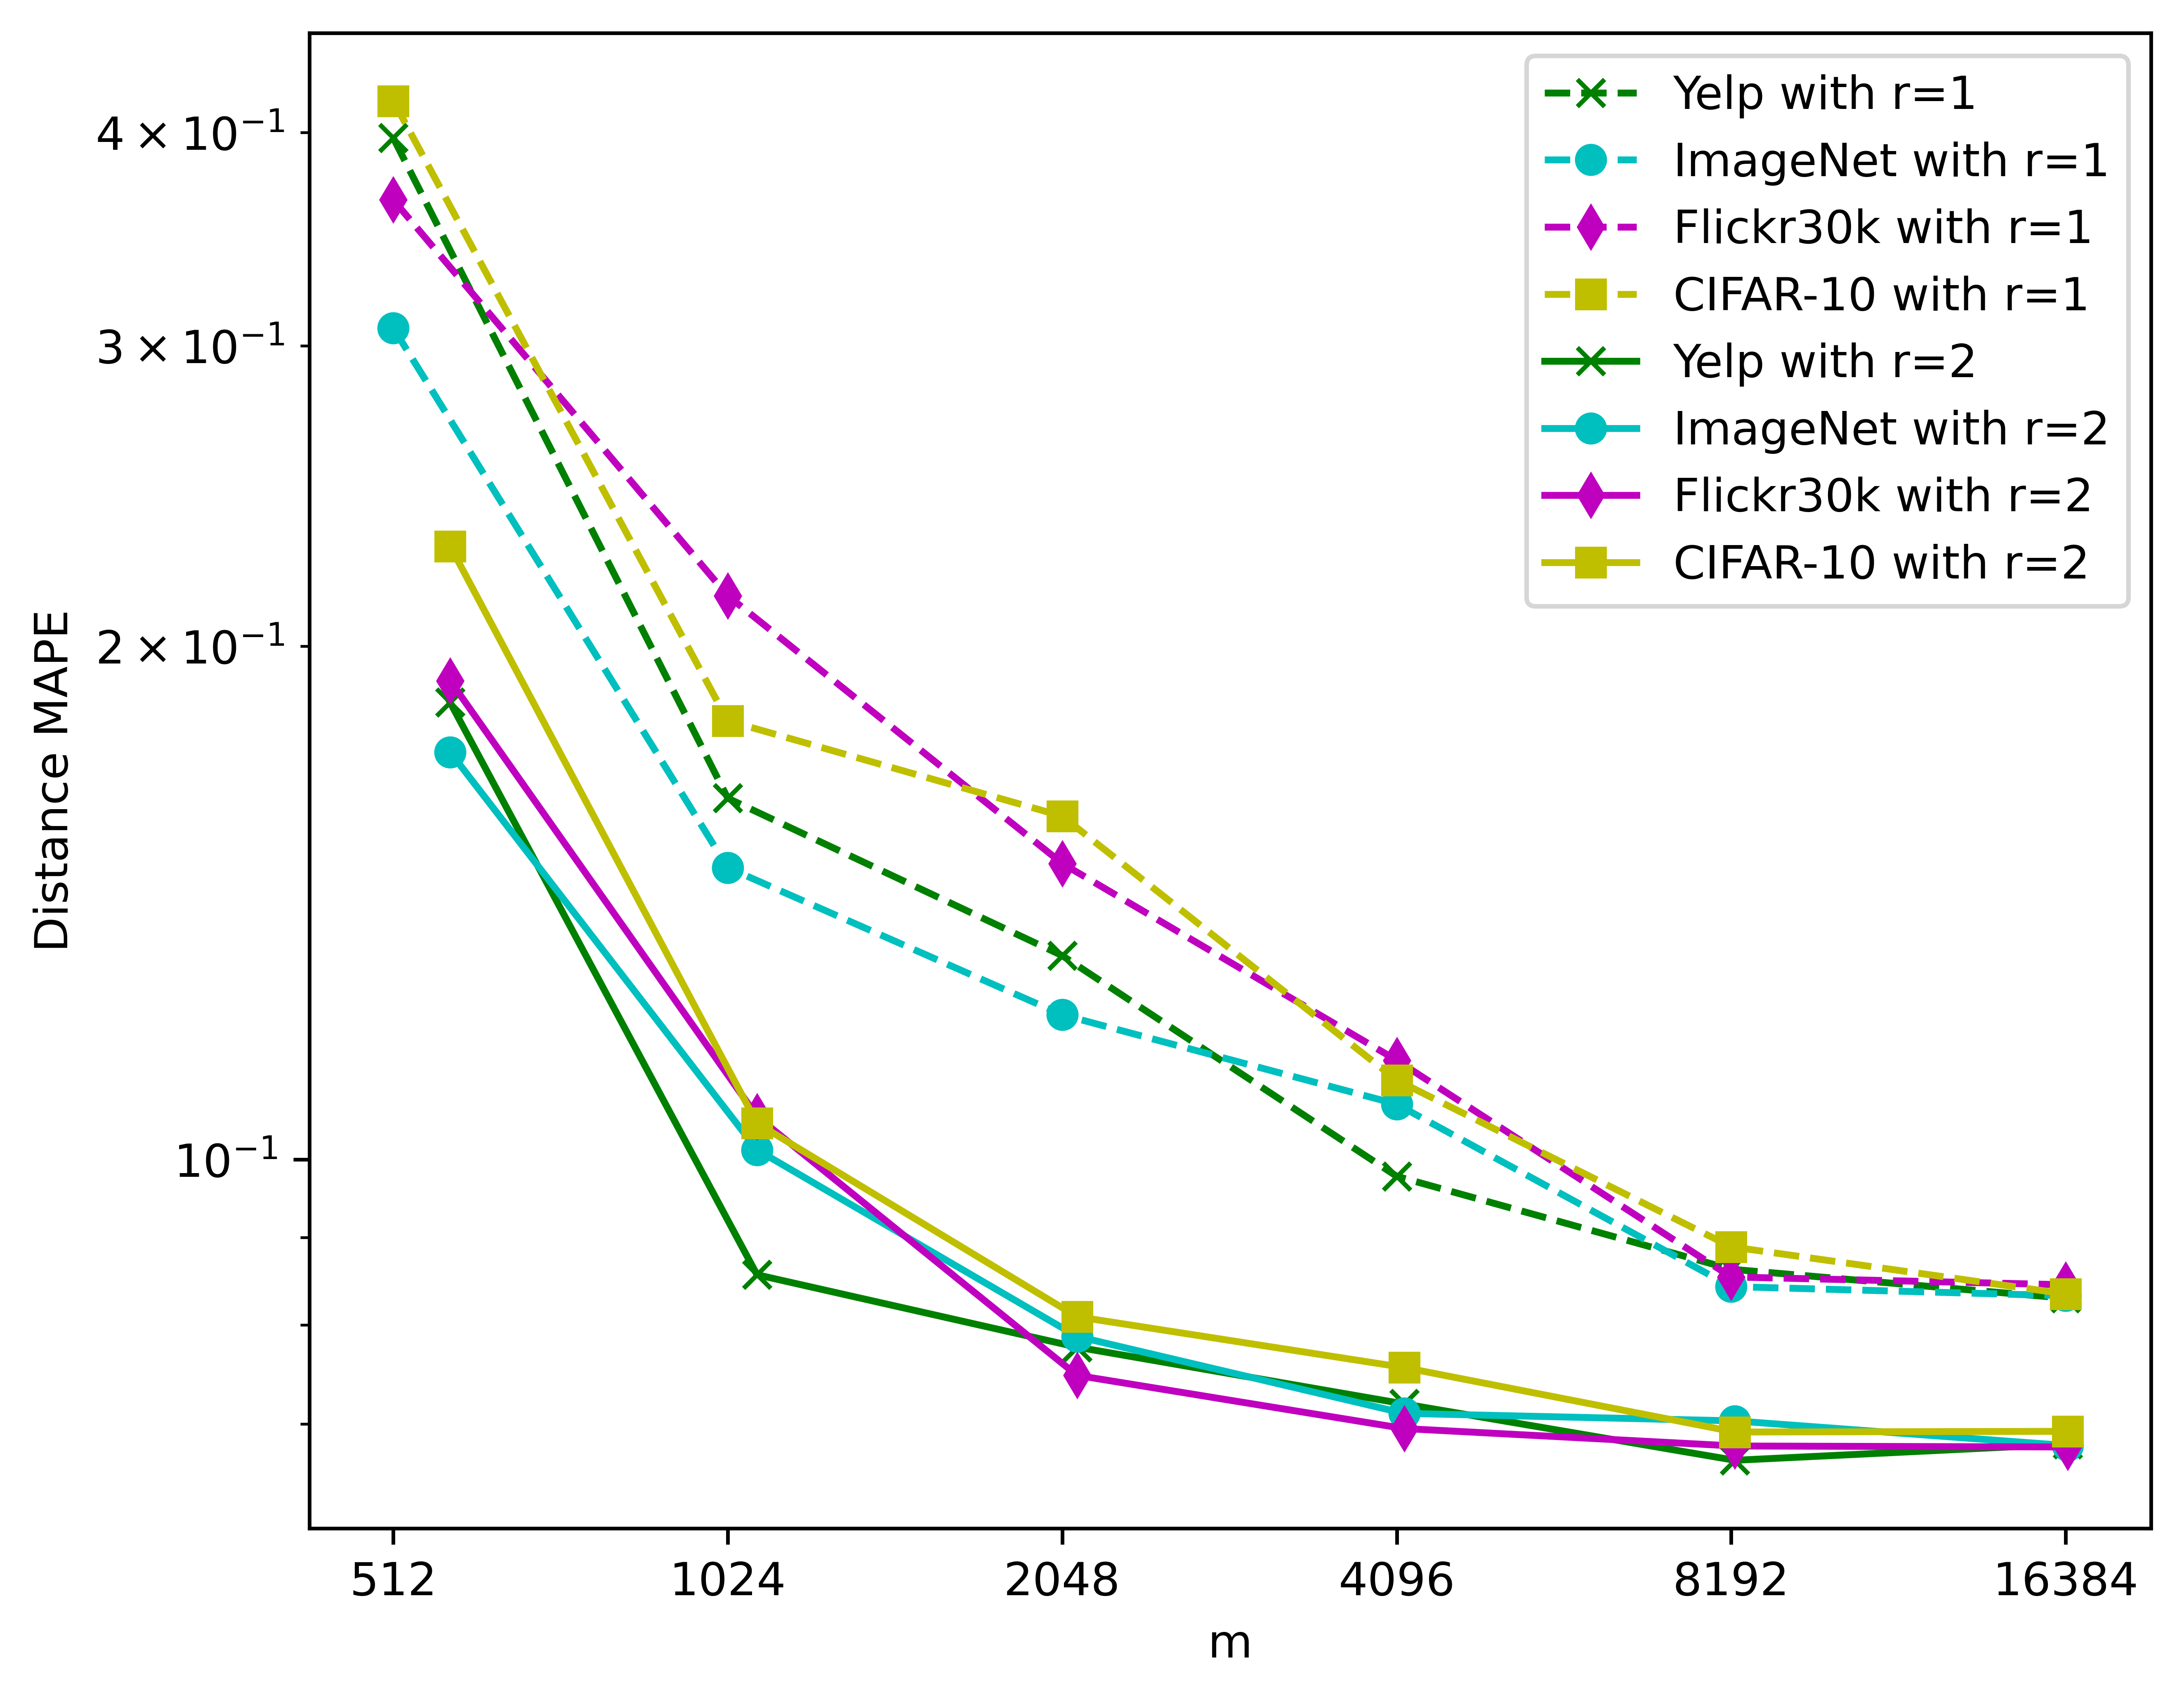

In [85]:
col = ['g', 'c', 'm', 'y']     
mar = ['x', 'o', 'd', 's']
datasets = ['Yelp', 'ImageNet', 'Flickr30k', 'CIFAR-10']
fig = plt.figure(figsize=(7.2,6), dpi=800)
ax = fig.add_subplot(1,1,1)

for i in range(mse_dist1.shape[0]):
    ax.plot(m_list1, mse_dist1[i,:], color=col[i], linestyle='--', marker=mar[i], label = datasets[i]+' with r=1')
for i in range(mse_dist1.shape[0]):
    ax.plot(m_list2, mse_dist2[i,:], color=col[i], linestyle='-', marker=mar[i], label = datasets[i]+ ' with r=2')

# ax.plot(m_list, [165*m**(-0.8) for m in m_list], color='y', linestyle='-', label = '$y=165m^{-0.8}$')
# 'Distance MSE', 'Norm MSE', 'Distance MSE', 'Norm MSE'
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log', base=2)
ax.set_xticks(m_list1)
ax.set_xticklabels(m_list1)
ax.set_xlabel('m')
ax.set_ylabel('Distance MAPE')